In [1]:
%matplotlib inline
import pickle
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc

In [2]:
def load_data(dirname, filename):
    currdir = os.getcwd()
    datadir = os.path.abspath(os.path.join(currdir, dirname))
    return os.path.abspath(os.path.join(datadir, filename))

def generate_xy_grids(xrange, yrange):
    x = np.arange(xrange[0], xrange[1], xrange[2])
    y = np.arange(yrange[0], yrange[1], yrange[2])

    return np.meshgrid(x, y)

In [3]:
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 46cm so it has a radius of 23cm, which is a value
    # 2.3 in our coordinate system
    hoop = Circle((0, 0), radius=2.3, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-9, -2.3), 18, -0.1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=4.9m, height=5.8m
    outer_box = Rectangle((-24.45, -14.3), 49, 58, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=3.6ft, height=5.8ft
    inner_box = Rectangle((-18, -14.3), 36, 58, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 43.7), 36, 36, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 43.7), 36, 36, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 25, 25, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 2.68m long before they begin to arc
    corner_three_a = Rectangle((-66, -14.3), 0, 28.8, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((66, -14.3), 0, 28.8, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 6.75m away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 135, 135, theta1=12, theta2=168, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 125.7), 36, 36, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 125.7), 12, 12, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [
        hoop,
        backboard,
        outer_box,
        inner_box,
        top_free_throw,
        bottom_free_throw,
        restricted,
        corner_three_a,
        corner_three_b,
        three_arc,
        center_outer_arc,
        center_inner_arc
    ]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-75, -14.3), 150, 140, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [4]:
dirname = 'outputs/data/'
ebppa = 'ebppa_noneg.csv'

df_ebppa = pd.read_csv(load_data(dirname, ebppa))
np_ebppa = df_ebppa.to_numpy()

playersfg = 'players-retained-fg.csv'

df_fg = pd.read_csv(load_data(dirname, playersfg))
np_fg = df_fg.to_numpy()

XX,YY = generate_xy_grids((-75,75,5), (-15,125,5))    #xx = array of x-coordinates; yy = array of y-coordinates
GRID_Y, GRID_X = XX.shape                             # gridy = number of rows = cells along sideline (y); gridx = number of cols = cells along baseline (x);

players = df_fg['player'].unique()
teams = df_fg['team'].unique()

In [5]:
def get_player_fg_grid(player):
      
    df_player = df_fg[df_fg.player==player]
    grid_fga = np.empty(XX.shape)
    grid_fg = np.empty(XX.shape)
    grid_pts = np.empty(XX.shape)
    grid_ppa = np.empty(XX.shape)
    
    for y in range(0, GRID_Y):
        for x in range(0, GRID_X):
            fga = df_player[(df_player.x.isin(range(XX[y][x],XX[y][x] + 5))) & (df_player.y.isin(range(YY[y][x],YY[y][x] + 5)))]
            fg = df_player[(df_player.x.isin(range(XX[y][x],XX[y][x] + 5))) & (df_player.y.isin(range(YY[y][x],YY[y][x] + 5))) & (df_player.made==1)]
            pts = fg.made_points.sum()
            if len(fga) > 0:
                ppa = pts/len(fga)
            else:
                ppa = 0

            grid_fga[y][x] = len(fga)
            grid_fg[y][x] = len(fg)
            grid_pts[y][x] = pts
            grid_ppa[y][x] = ppa
    
    return {'fga': grid_fga, 'fg': grid_fg, 'pts': grid_pts, 'ppa': grid_ppa, 'team': df_player['team'].unique()[0]}
    

In [6]:
stats_players = []

for pl in players:
    grid_pl = get_player_fg_grid(pl)
    team = grid_pl['team']
    grid_fga = grid_pl['fga']
    grid_fg = grid_pl['fg']
    grid_pts = grid_pl['pts']
    grid_ppa = grid_pl['ppa']
#     ppa = (np.sum(grid_pl['pts'])/np.sum(grid_pl['fga'])).round(3)
    grid_elpts = (np.multiply(grid_pl['fga'], np_ebppa)).round(3)
#     grid_lppa = np.divide(grid_pts, grid_fga, out=np.zeros_like(grid_pts), where=grid_fga!=0)
#     elpts = np.sum(elptsk).round(3)
#     eppa = (elpts/np.sum(grid_pl['fga'])).round(3)
    grid_ssce = np.subtract(grid_ppa, np_ebppa).round(3)
    grid_prla = np.subtract(grid_pts, grid_elpts).round(3)
    
    stats_players.append([pl, team, grid_ssce, grid_prla, grid_ppa, grid_elpts, grid_fg, grid_fga, grid_pts])

# print(stats_players)

df_stats_players = pd.DataFrame(stats_players, columns=['player', 'team', 'grid_ssce', 'grid_prla', 'grid_lppa', 'grid_elpts', 'grid_fg', 'grid_fga', 'grid_pts'])

# df_stats_players.to_csv("outputs/data/player-analysis-global.csv", index=False)

In [11]:
# object = df_stats_players
filehandler = open('outputs/data/local-stats/local-stats.obj', 'wb') 
pickle.dump(df_stats_players, filehandler)

In [12]:
filetoload = open('outputs/data/local-stats/local-stats.obj', 'rb')
df_loaded = pickle.load(filetoload)

In [7]:
# for i in df_stats_players.index:
#     ssce = df_stats_players['grid_ssce'][i]
#     prla = df_stats_players['grid_prla'][i]



In [15]:
grid_ssce = df_stats_players['grid_ssce']
# grid_ssce[0]

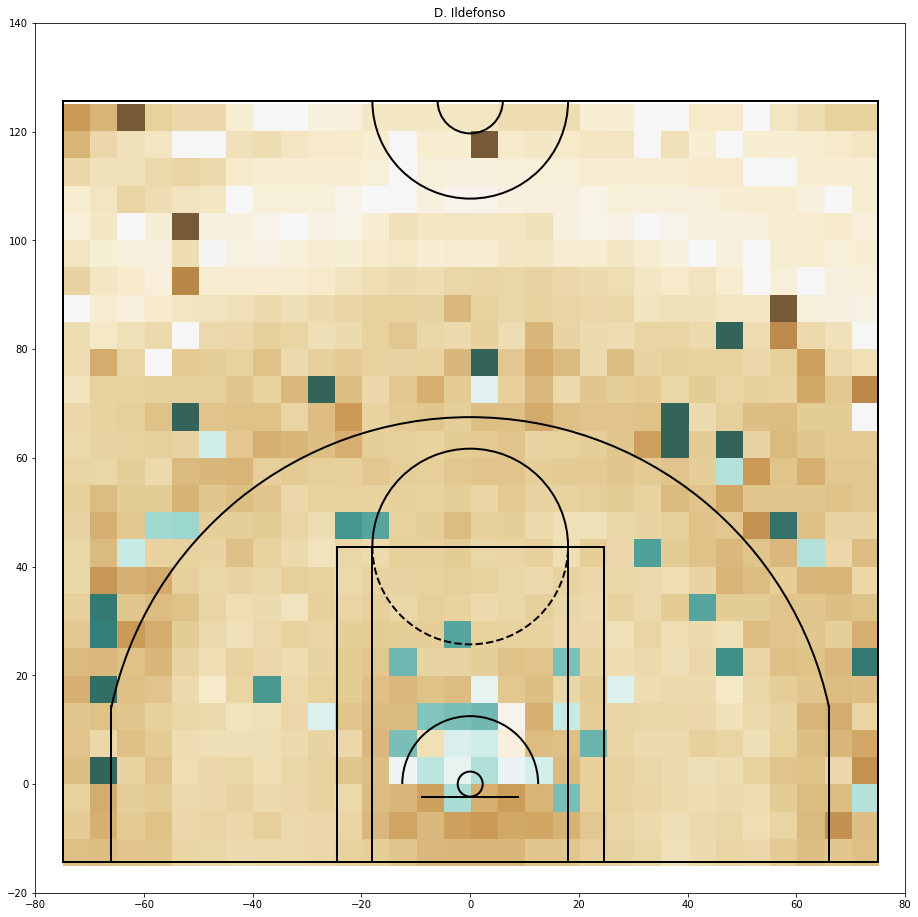

In [21]:
plt.figure(figsize=(18,16))

nn = 3

plt.imshow(df_stats_players['grid_ssce'][nn], cmap=plt.cm.BrBG, alpha=0.8, vmin=-2, vmax=2, interpolation='none', extent=(-75,75,-15,125), origin='lower')
draw_court(outer_lines=True)

plt.xlim(-80,80)
plt.ylim(-20, 140)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().set_facecolor('#ffffff')
plt.gca().set_title(df_stats_players['player'][nn])

# plt.savefig('outputs/img/ebppa/ppa.png')
# plt.savefig('outputs/img/ebppa/eb-ppa.png')
plt.show()
plt.close()